In [28]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 랜덤 시드 설정
torch.manual_seed(42)
np.random.seed(42)

In [29]:
# 데이터 로드
person_df = pd.read_csv('person.csv')
chair_df = pd.read_excel('chair.xlsx')

print("Person data shape:", person_df.shape)
print("Chair data shape:", chair_df.shape)
print("\nPerson columns:", person_df.columns.tolist())
print("\nChair columns:", chair_df.columns.tolist())

Person data shape: (14, 7)
Chair data shape: (107, 18)

Person columns: ['image-name', 'human-height', 'A_Buttock-popliteal length', 'B_Popliteal-height', 'C_Hip-breadth', 'F_Sitting-height', 'G_Shoulder-breadth']

Chair columns: ['링크', '브랜드명', '제품명', '가격', '별점', '리뷰 갯수', '헤드레스트 유무', '팔걸이 유무', '요추지지대 유무', '높이 조절 레버 유무', '틸팅 여부', '등받이 곧/꺾', 'h8_지면-좌석 높이_MIN', 'h8_지면-좌석 높이_MAX', 'b3_좌석 가로 길이', 't4_좌석 세로 길이 일반', 'b4_등받이 가로 길이', 'h7_등받이 세로 길이']


In [30]:
# 데이터 전처리 함수
def preprocess_data(person_df, chair_df):
    # Person 데이터 전처리 (cm 단위)
    person_features = ['A_Buttock-popliteal length', 'B_Popliteal-height', 
                      'C_Hip-breadth', 
                      'G_Shoulder-breadth']
    
    # 결측치 처리 - 각 컬럼의 평균값으로 대체
    for col in person_features:
        if col in person_df.columns:
            person_df[col].fillna(person_df[col].mean(), inplace=True)
    
    # Chair 데이터 전처리 (mm -> cm 변환)
    # 범위형 데이터를 중간값으로 변환
    chair_processed = pd.DataFrame()
    chair_processed['chair_id'] = chair_df.index
    
    # 매칭에 필요한 의자 특성 추출 및 단위 변환 (mm -> cm)
    # t4 (좌석 깊이)
    if 't4' in chair_df.columns:
        chair_processed['t4'] = chair_df['t4'] / 10  # mm to cm
    
    # h8 (지면-좌석 높이) - 범위형 데이터 처리
    if 'h8_지면-좌석 높이_MIN' in chair_df.columns and 'h8_지면-좌석 높이_MAX' in chair_df.columns:
        chair_processed['h8'] = (chair_df['h8_지면-좌석 높이_MIN'] + chair_df['h8_지면-좌석 높이_MAX']) / 2 / 10
        chair_processed['h8_range'] = (chair_df['h8_지면-좌석 높이_MAX'] - chair_df['h8_지면-좌석 높이_MIN']) / 10
    
    # b3 (좌석 가로 길이)
    if 'b3_좌석 가로 길이' in chair_df.columns:
        chair_processed['b3'] = chair_df['b3_좌석 가로 길이'] / 10
    
    # h7 (등받이 세로 길이)
    if 'h7_등받이 세로 길이' in chair_df.columns:
        chair_processed['h7'] = chair_df['h7_등받이 세로 길이'] / 10
    
    # b4 (등받이 가로 길이)
    if 'b4_등받이 가로 길이' in chair_df.columns:
        chair_processed['b4'] = chair_df['b4_등받이 가로 길이'] / 10
    
    # 결측치 처리
    chair_processed.fillna(chair_processed.mean(), inplace=True)
    
    return person_df[['image-name'] + person_features], chair_processed

In [31]:
# 데이터 전처리 실행
person_processed, chair_processed = preprocess_data(person_df, chair_df)
print("Processed person data shape:", person_processed.shape)
print("Processed chair data shape:", chair_processed.shape)

Processed person data shape: (14, 5)
Processed chair data shape: (107, 6)


In [ ]:
def create_matching_labels(person_data, chair_data):
    """
    사람과 의자의 매칭 조건에 따라 레이블 생성
    조건:
    - t4 < A (좌석 깊이 < 허벅지 길이)
    - h8 ≈ B (좌석 높이 ≈ 앉은 다리 높이, ±5cm 허용)
    - b3 > C (좌석 가로 > 엉덩이 폭)
    - h9 ≈ E (팔걸이 높이 ≈ 팔꿈치 높이, ±3cm 허용)
    - b4 ≥ G (등받이 가로 ≥ 어깨 너비)
    """
    n_persons = len(person_data)
    n_chairs = len(chair_data)
    
    # 모든 사람-의자 조합에 대한 매칭 점수 계산
    matching_scores = np.zeros((n_persons, n_chairs))
    
    for i in range(n_persons):
        person = person_data.iloc[i]
        for j in range(n_chairs):
            chair = chair_data.iloc[j]
            score = 0
            
            # 각 조건 확인
            if 't4' in chair and chair['t4'] < person['A_Buttock-popliteal length']:
                score += 1
            
            if 'h8' in chair and abs(chair['h8'] - person['B_Popliteal-height']) <= 5:
                score += 1
            
            if 'b3' in chair and chair['b3'] > person['C_Hip-breadth']:
                score += 1
            
            if 'h9' in chair and abs(chair['h9'] - person['E_Elbow-rest-height']) <= 3:
                score += 1
            
            if 'b4' in chair and chair['b4'] >= person['G_Shoulder-breadth']:
                score += 1
            
            # 점수를 0-1로 정규화
            matching_scores[i, j] = score / 5.0  # 6.0을 5.0으로 수정함
    
    return matching_scores

In [33]:
# 매칭 레이블 생성
matching_labels = create_matching_labels(person_processed, chair_processed)
print("Matching labels shape:", matching_labels.shape)
print("Average matching score:", matching_labels.mean())
print("Max matching score:", matching_labels.max())
print("Min matching score:", matching_labels.min())

Matching labels shape: (14, 107)
Average matching score: 0.279595015576324
Max matching score: 0.5
Min matching score: 0.0


In [34]:
class cVAE(nn.Module):
    def __init__(self, person_dim, chair_dim, latent_dim=20, hidden_dim=100):
        super(cVAE, self).__init__()
        
        # Encoder: 사람 특성 -> 잠재 공간
        self.encoder_fc1 = nn.Linear(person_dim, hidden_dim)
        self.encoder_fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.encoder_mean = nn.Linear(hidden_dim // 2, latent_dim)
        self.encoder_logvar = nn.Linear(hidden_dim // 2, latent_dim)
        
        # Decoder: 잠재 변수 + 의자 특성 -> 매칭 점수
        self.decoder_fc1 = nn.Linear(latent_dim + chair_dim, hidden_dim)
        self.decoder_fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.decoder_output = nn.Linear(hidden_dim // 2, 1)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
        
    def encode(self, x):
        h = self.relu(self.encoder_fc1(x))
        h = self.dropout(h)
        h = self.relu(self.encoder_fc2(h))
        return self.encoder_mean(h), self.encoder_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, condition):
        # 잠재 변수와 의자 특성 연결
        combined = torch.cat([z, condition], dim=1)
        h = self.relu(self.decoder_fc1(combined))
        h = self.dropout(h)
        h = self.relu(self.decoder_fc2(h))
        return self.sigmoid(self.decoder_output(h))
    
    def forward(self, person_features, chair_features):
        mu, logvar = self.encode(person_features)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, chair_features), mu, logvar

In [35]:
class ChairRecommendationDataset(Dataset):
    def __init__(self, person_features, chair_features, labels):
        self.person_features = torch.FloatTensor(person_features)
        self.chair_features = torch.FloatTensor(chair_features)
        self.labels = torch.FloatTensor(labels)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # idx를 person_idx와 chair_idx로 변환
        n_chairs = self.chair_features.shape[0]
        person_idx = idx // n_chairs
        chair_idx = idx % n_chairs
        
        return (self.person_features[person_idx], 
                self.chair_features[chair_idx], 
                self.labels[person_idx, chair_idx])

In [36]:
# 데이터 준비
# 특성 추출 (image-name 제외)
person_features = person_processed.drop('image-name', axis=1).values
chair_features = chair_processed.drop('chair_id', axis=1).values

# 데이터 정규화
person_scaler = StandardScaler()
chair_scaler = StandardScaler()

person_features_scaled = person_scaler.fit_transform(person_features)
chair_features_scaled = chair_scaler.fit_transform(chair_features)

# 학습/검증 데이터 분할 (사람 기준으로 분할)
n_persons = len(person_features_scaled)
train_idx, val_idx = train_test_split(range(n_persons), test_size=0.2, random_state=42)

# 학습/검증 레이블 분리
train_labels = matching_labels[train_idx]
val_labels = matching_labels[val_idx]

print(f"Train persons: {len(train_idx)}, Val persons: {len(val_idx)}")
print(f"Total train samples: {len(train_idx) * len(chair_features_scaled)}")
print(f"Total val samples: {len(val_idx) * len(chair_features_scaled)}")

Train persons: 11, Val persons: 3
Total train samples: 1177
Total val samples: 321


In [37]:
# 데이터셋 생성
train_dataset = ChairRecommendationDataset(
    person_features_scaled[train_idx], 
    chair_features_scaled, 
    train_labels
)

val_dataset = ChairRecommendationDataset(
    person_features_scaled[val_idx], 
    chair_features_scaled, 
    val_labels
)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [38]:
def loss_function(recon_x, x, mu, logvar, beta=1.0):
    """
    cVAE 손실 함수
    - Reconstruction loss: BCE
    - KL divergence loss
    """
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

In [39]:
# 모델 초기화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = cVAE(
    person_dim=person_features_scaled.shape[1],
    chair_dim=chair_features_scaled.shape[1],
    latent_dim=20,
    hidden_dim=100
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

Using device: cpu


In [40]:
# 학습 함수
def train_epoch(model, train_loader, optimizer, device, beta=1.0):
    model.train()
    train_loss = 0
    
    for batch_idx, (person_feat, chair_feat, labels) in enumerate(train_loader):
        person_feat = person_feat.to(device)
        chair_feat = chair_feat.to(device)
        labels = labels.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(person_feat, chair_feat)
        loss = loss_function(recon_batch, labels, mu, logvar, beta)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    return train_loss / len(train_loader.dataset)

def validate(model, val_loader, device, beta=1.0):
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for person_feat, chair_feat, labels in val_loader:
            person_feat = person_feat.to(device)
            chair_feat = chair_feat.to(device)
            labels = labels.to(device).unsqueeze(1)
            
            recon_batch, mu, logvar = model(person_feat, chair_feat)
            val_loss += loss_function(recon_batch, labels, mu, logvar, beta).item()
    
    return val_loss / len(val_loader.dataset)

In [41]:
# 모델 학습
n_epochs = 100
train_losses = []
val_losses = []
best_val_loss = float('inf')
beta = 0.5  # KL divergence weight

for epoch in range(n_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, device, beta)
    val_loss = validate(model, val_loader, device, beta)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_cvae_model.pt')
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch 10/100, Train Loss: 0.6965, Val Loss: 0.7319
Epoch 20/100, Train Loss: 0.6827, Val Loss: 0.6991
Epoch 30/100, Train Loss: 0.6750, Val Loss: 0.6869
Epoch 40/100, Train Loss: 0.6694, Val Loss: 0.6816
Epoch 50/100, Train Loss: 0.6686, Val Loss: 0.6744
Epoch 60/100, Train Loss: 0.6685, Val Loss: 0.6793
Epoch 70/100, Train Loss: 0.6638, Val Loss: 0.6761
Epoch 80/100, Train Loss: 0.6662, Val Loss: 0.6785
Epoch 90/100, Train Loss: 0.6618, Val Loss: 0.6861
Epoch 100/100, Train Loss: 0.6597, Val Loss: 0.6780


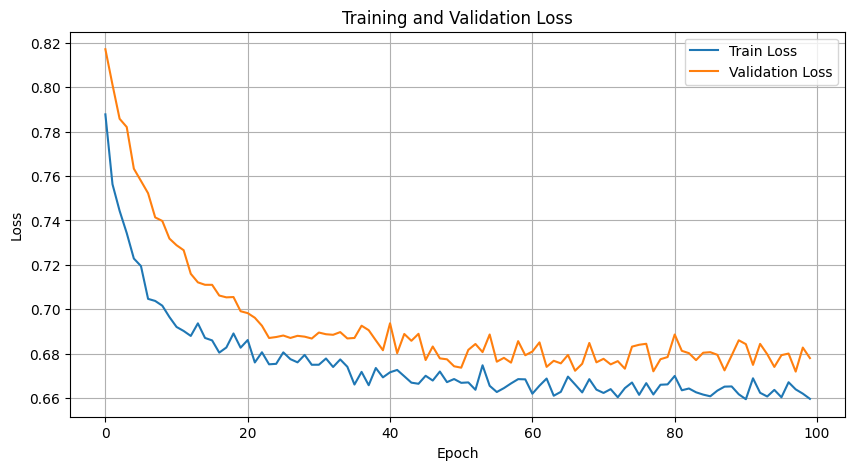

In [42]:
# 학습 곡선 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
def get_top_k_recommendations(model, person_features, chair_features, k=5):
    """
    각 사용자에 대해 Top-K 의자 추천
    """
    model.eval()
    n_persons = len(person_features)
    n_chairs = len(chair_features)
    
    recommendations = {}
    
    with torch.no_grad():
        for i in range(n_persons):
            person_feat = torch.FloatTensor(person_features[i:i+1]).repeat(n_chairs, 1).to(device)
            chair_feat = torch.FloatTensor(chair_features).to(device)
            
            # 모든 의자에 대한 점수 예측
            scores, _, _ = model(person_feat, chair_feat)
            scores = scores.squeeze().cpu().numpy()
            
            # Top-K 의자 선택
            top_k_indices = np.argsort(scores)[-k:][::-1]
            top_k_scores = scores[top_k_indices]
            
            recommendations[i] = {
                'chair_indices': top_k_indices,
                'scores': top_k_scores
            }
    
    return recommendations

In [44]:
# 최적 모델 로드
model.load_state_dict(torch.load('best_cvae_model.pt'))

# 모든 사용자에 대한 Top-K 추천 생성
k = 5
all_recommendations = get_top_k_recommendations(
    model, 
    person_features_scaled, 
    chair_features_scaled, 
    k=k
)

In [45]:
# 추천 결과 표시
print(f"\nTop-{k} 의자 추천 결과:\n")
for person_idx in range(min(5, len(person_processed))):  # 처음 5명만 표시
    print(f"사용자: {person_processed.iloc[person_idx]['image-name']}")
    print(f"신체 특성:")
    for col in person_processed.columns[1:]:
        print(f"  - {col}: {person_processed.iloc[person_idx][col]:.2f} cm")
    
    print(f"\n추천 의자:")
    rec = all_recommendations[person_idx]
    for rank, (chair_idx, score) in enumerate(zip(rec['chair_indices'], rec['scores'])):
        print(f"  {rank+1}. 의자 {chair_idx} (점수: {score:.4f})")
        # 실제 매칭 레이블과 비교
        actual_score = matching_labels[person_idx, chair_idx]
        print(f"     실제 매칭 점수: {actual_score:.4f}")
    print("-" * 50)


Top-5 의자 추천 결과:

사용자: test10
신체 특성:
  - A_Buttock-popliteal length: 45.01 cm
  - B_Popliteal-height: 40.14 cm
  - C_Hip-breadth: 42.44 cm
  - G_Shoulder-breadth: 50.09 cm

추천 의자:
  1. 의자 99 (점수: 0.5548)
     실제 매칭 점수: 0.3333
  2. 의자 10 (점수: 0.5415)
     실제 매칭 점수: 0.1667
  3. 의자 7 (점수: 0.5328)
     실제 매칭 점수: 0.1667
  4. 의자 67 (점수: 0.5295)
     실제 매칭 점수: 0.1667
  5. 의자 95 (점수: 0.5249)
     실제 매칭 점수: 0.3333
--------------------------------------------------
사용자: test11
신체 특성:
  - A_Buttock-popliteal length: 40.20 cm
  - B_Popliteal-height: 36.76 cm
  - C_Hip-breadth: 45.56 cm
  - G_Shoulder-breadth: 41.79 cm

추천 의자:
  1. 의자 99 (점수: 0.5555)
     실제 매칭 점수: 0.3333
  2. 의자 91 (점수: 0.5420)
     실제 매칭 점수: 0.3333
  3. 의자 10 (점수: 0.5396)
     실제 매칭 점수: 0.3333
  4. 의자 7 (점수: 0.5320)
     실제 매칭 점수: 0.3333
  5. 의자 95 (점수: 0.5110)
     실제 매칭 점수: 0.1667
--------------------------------------------------
사용자: test12
신체 특성:
  - A_Buttock-popliteal length: 46.02 cm
  - B_Popliteal-height: 44.49 cm
  - C

In [46]:
def evaluate_recommendations(recommendations, matching_labels, k=5):
    """
    추천 성능 평가
    - Precision@K: Top-K 중 실제로 좋은 매칭인 비율
    - Recall@K: 전체 좋은 매칭 중 Top-K에 포함된 비율
    - NDCG@K: 순위를 고려한 평가 지표
    """
    n_persons = len(recommendations)
    precisions = []
    recalls = []
    ndcgs = []
    
    threshold = 0.5  # 좋은 매칭으로 간주하는 점수 임계값
    
    for person_idx in range(n_persons):
        rec = recommendations[person_idx]
        top_k_chairs = rec['chair_indices']
        
        # 실제 좋은 매칭 의자들
        good_chairs = np.where(matching_labels[person_idx] >= threshold)[0]
        
        if len(good_chairs) == 0:
            continue
        
        # Precision@K
        hits = sum([1 for chair in top_k_chairs if chair in good_chairs])
        precision = hits / k
        precisions.append(precision)
        
        # Recall@K
        recall = hits / len(good_chairs)
        recalls.append(recall)
        
        # NDCG@K
        dcg = 0
        for i, chair in enumerate(top_k_chairs):
            if chair in good_chairs:
                dcg += 1 / np.log2(i + 2)
        
        ideal_dcg = sum([1 / np.log2(i + 2) for i in range(min(k, len(good_chairs)))])
        ndcg = dcg / ideal_dcg if ideal_dcg > 0 else 0
        ndcgs.append(ndcg)
    
    return {
        'precision@k': np.mean(precisions),
        'recall@k': np.mean(recalls),
        'ndcg@k': np.mean(ndcgs)
    }

In [47]:
# 전체 데이터셋에 대한 성능 평가
metrics = evaluate_recommendations(all_recommendations, matching_labels, k=k)

print(f"\n추천 시스템 성능 평가 (Top-{k}):")
print(f"Precision@{k}: {metrics['precision@k']:.4f}")
print(f"Recall@{k}: {metrics['recall@k']:.4f}")
print(f"NDCG@{k}: {metrics['ndcg@k']:.4f}")


추천 시스템 성능 평가 (Top-5):
Precision@5: 0.2800
Recall@5: 0.1263
NDCG@5: 0.2553


In [48]:
# 검증 세트에 대한 성능 평가
val_recommendations = get_top_k_recommendations(
    model, 
    person_features_scaled[val_idx], 
    chair_features_scaled, 
    k=k
)

val_metrics = evaluate_recommendations(val_recommendations, val_labels, k=k)

print(f"\n검증 세트 성능 평가 (Top-{k}):")
print(f"Precision@{k}: {val_metrics['precision@k']:.4f}")
print(f"Recall@{k}: {val_metrics['recall@k']:.4f}")
print(f"NDCG@{k}: {val_metrics['ndcg@k']:.4f}")


검증 세트 성능 평가 (Top-5):
Precision@5: 0.2667
Recall@5: 0.0537
NDCG@5: 0.2719


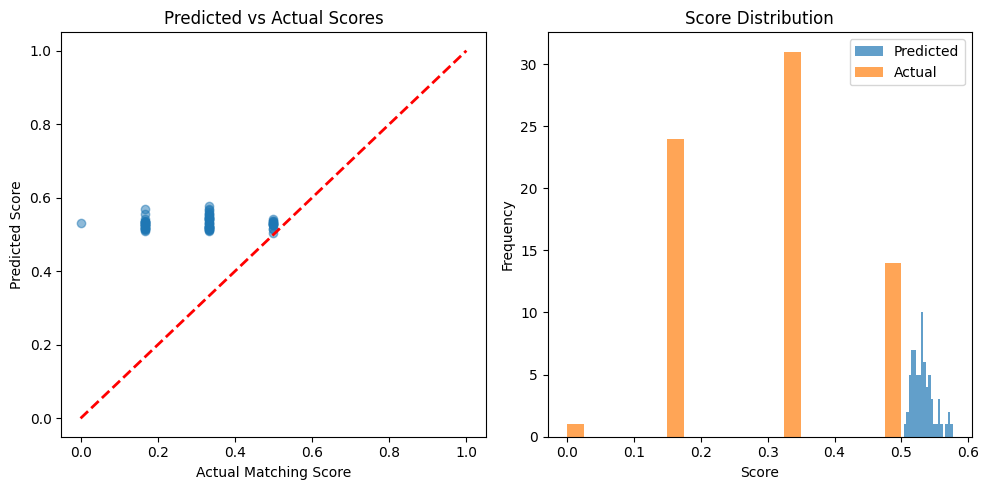

In [49]:
# 추천 점수 분포 시각화
all_predicted_scores = []
all_actual_scores = []

for person_idx in range(len(person_features_scaled)):
    rec = all_recommendations[person_idx]
    for chair_idx, pred_score in zip(rec['chair_indices'], rec['scores']):
        all_predicted_scores.append(pred_score)
        all_actual_scores.append(matching_labels[person_idx, chair_idx])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(all_actual_scores, all_predicted_scores, alpha=0.5)
plt.xlabel('Actual Matching Score')
plt.ylabel('Predicted Score')
plt.title('Predicted vs Actual Scores')
plt.plot([0, 1], [0, 1], 'r--', lw=2)

plt.subplot(1, 2, 2)
plt.hist(all_predicted_scores, bins=20, alpha=0.7, label='Predicted')
plt.hist(all_actual_scores, bins=20, alpha=0.7, label='Actual')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Score Distribution')
plt.legend()

plt.tight_layout()
plt.show()

In [50]:
# 추천 결과를 DataFrame으로 저장
recommendation_results = []

for person_idx in range(len(person_processed)):
    person_name = person_processed.iloc[person_idx]['image-name']
    rec = all_recommendations[person_idx]
    
    for rank, (chair_idx, score) in enumerate(zip(rec['chair_indices'], rec['scores'])):
        recommendation_results.append({
            'person': person_name,
            'person_idx': person_idx,
            'rank': rank + 1,
            'chair_idx': chair_idx,
            'predicted_score': score,
            'actual_score': matching_labels[person_idx, chair_idx]
        })

results_df = pd.DataFrame(recommendation_results)
results_df.to_csv('chair_recommendations.cVAE.csv', index=False)
print("추천 결과가 'chair_recommendations.cVAE.csv'에 저장되었습니다.")

추천 결과가 'chair_recommendations.cVAE.csv'에 저장되었습니다.


In [51]:
# 테스트 데이터 로드
person_test_df = pd.read_excel('person_test.xlsx')
print("Test person data shape:", person_test_df.shape)
print("Test person columns:", person_test_df.columns.tolist())

Test person data shape: (4, 7)
Test person columns: ['image-name', 'human-height', 'A_Buttock-popliteal length', 'B_Popliteal-height', 'C_Hip-breadth', 'F_Sitting-height', 'G_Shoulder-breadth']


In [52]:
# 테스트 데이터 전처리
def preprocess_test_data(person_test_df):
    # Person 데이터 전처리 (cm 단위)
    person_features = ['A_Buttock-popliteal length', 'B_Popliteal-height', 
                      'C_Hip-breadth', 
                      'G_Shoulder-breadth']
    
    # 결측치 처리 - 학습 데이터의 평균값으로 대체
    for col in person_features:
        if col in person_test_df.columns:
            # 학습 데이터의 평균값 사용
            train_mean = person_processed[col].mean()
            person_test_df[col].fillna(train_mean, inplace=True)
    
    return person_test_df[['image-name'] + person_features]

# 테스트 데이터 전처리
person_test_processed = preprocess_test_data(person_test_df.copy())
print("Processed test person data shape:", person_test_processed.shape)

Processed test person data shape: (4, 5)


In [53]:
# 테스트 데이터를 위한 추천 생성 함수
def get_test_recommendations(model, person_test_features, chair_features, person_scaler, k=5):
    """
    테스트 사용자에 대해 Top-K 의자 추천
    """
    model.eval()
    n_test_persons = len(person_test_features)
    n_chairs = len(chair_features)
    
    # 테스트 데이터 정규화 (학습 데이터의 scaler 사용)
    person_test_scaled = person_scaler.transform(person_test_features)
    
    recommendations = {}
    all_scores = np.zeros((n_test_persons, n_chairs))
    
    with torch.no_grad():
        for i in range(n_test_persons):
            person_feat = torch.FloatTensor(person_test_scaled[i:i+1]).repeat(n_chairs, 1).to(device)
            chair_feat = torch.FloatTensor(chair_features).to(device)
            
            # 모든 의자에 대한 점수 예측
            scores, _, _ = model(person_feat, chair_feat)
            scores = scores.squeeze().cpu().numpy()
            all_scores[i] = scores
            
            # Top-K 의자 선택
            top_k_indices = np.argsort(scores)[-k:][::-1]
            top_k_scores = scores[top_k_indices]
            
            recommendations[i] = {
                'chair_indices': top_k_indices,
                'scores': top_k_scores
            }
    
    return recommendations, all_scores

In [54]:
# 테스트 데이터 특성 추출
person_test_features = person_test_processed.drop('image-name', axis=1).values

# 테스트 사용자에 대한 추천 생성
test_recommendations, test_all_scores = get_test_recommendations(
    model, 
    person_test_features, 
    chair_features_scaled,
    person_scaler,
    k=5
)

print(f"Generated recommendations for {len(test_recommendations)} test users")

Generated recommendations for 4 test users


In [55]:
# 테스트 추천 결과 상세 표시
print(f"\n테스트 데이터 Top-5 의자 추천 결과:\n")

for person_idx in range(len(person_test_processed)):
    print(f"테스트 사용자: {person_test_processed.iloc[person_idx]['image-name']}")
    print(f"신체 특성:")
    for col in person_test_processed.columns[1:]:
        print(f"  - {col}: {person_test_processed.iloc[person_idx][col]:.2f} cm")
    
    print(f"\n추천 의자:")
    rec = test_recommendations[person_idx]
    
    for rank, (chair_idx, score) in enumerate(zip(rec['chair_indices'], rec['scores'])):
        # 의자 이름 복원 (chair_df의 원본 인덱스 사용)
        if chair_idx < len(chair_df):
            chair_name = f"Chair_{chair_idx}"
            # 의자의 실제 사양 표시
            print(f"\n  {rank+1}. {chair_name} (예측 점수: {score:.4f})")
            
            # 의자 사양 표시
            chair_specs = chair_processed.iloc[chair_idx]
            print(f"     의자 사양:")
            for spec_name, spec_value in chair_specs.items():
                if spec_name != 'chair_id':
                    print(f"       - {spec_name}: {spec_value:.2f} cm")
    
    print("\n" + "="*80 + "\n")


테스트 데이터 Top-5 의자 추천 결과:

테스트 사용자: 할머니
신체 특성:
  - A_Buttock-popliteal length: 52.00 cm
  - B_Popliteal-height: 35.00 cm
  - C_Hip-breadth: 32.00 cm
  - G_Shoulder-breadth: 33.00 cm

추천 의자:

  1. Chair_99 (예측 점수: 0.5509)
     의자 사양:
       - h8: 50.00 cm
       - h8_range: 2.00 cm
       - b3: 69.00 cm
       - h7: 67.00 cm
       - b4: 51.00 cm

  2. Chair_10 (예측 점수: 0.5391)
     의자 사양:
       - h8: 46.00 cm
       - h8_range: 10.00 cm
       - b3: 65.50 cm
       - h7: 38.00 cm
       - b4: 48.45 cm

  3. Chair_5 (예측 점수: 0.5315)
     의자 사양:
       - h8: 43.50 cm
       - h8_range: 0.00 cm
       - b3: 46.00 cm
       - h7: 37.00 cm
       - b4: 46.00 cm

  4. Chair_6 (예측 점수: 0.5295)
     의자 사양:
       - h8: 46.84 cm
       - h8_range: 6.09 cm
       - b3: 49.48 cm
       - h7: 56.58 cm
       - b4: 65.00 cm

  5. Chair_7 (예측 점수: 0.5272)
     의자 사양:
       - h8: 45.50 cm
       - h8_range: 0.00 cm
       - b3: 49.50 cm
       - h7: 46.00 cm
       - b4: 49.50 cm


테스트 사용자: 다온
신체 특성:
  

In [56]:
# 테스트 결과를 상세 DataFrame으로 저장
test_recommendation_results = []

for person_idx in range(len(person_test_processed)):
    person_name = person_test_processed.iloc[person_idx]['image-name']
    rec = test_recommendations[person_idx]
    
    # 사용자 신체 정보 저장
    person_info = person_test_processed.iloc[person_idx].to_dict()
    
    for rank, (chair_idx, score) in enumerate(zip(rec['chair_indices'], rec['scores'])):
        result_row = {
            'person': person_name,
            'rank': rank + 1,
            'chair_idx': chair_idx,
            'predicted_score': score,
        }
        
        # 사용자 신체 정보 추가
        for col in person_test_processed.columns[1:]:
            result_row[f'person_{col}'] = person_info[col]
        
        # 의자 사양 정보 추가
        chair_specs = chair_processed.iloc[chair_idx]
        for spec_name, spec_value in chair_specs.items():
            if spec_name != 'chair_id':
                result_row[f'chair_{spec_name}'] = spec_value
        
        test_recommendation_results.append(result_row)

# DataFrame으로 변환 및 저장
test_results_df = pd.DataFrame(test_recommendation_results)
test_results_df.to_csv('test_chair_recommendations.cVAE.csv', index=False)
# test_results_df.to_excel('test_chair_recommendations.xlsx', index=False)
print("테스트 추천 결과가 'test_chair_recommendations.csv'와 'test_chair_recommendations.xlsx'에 저장되었습니다.")

테스트 추천 결과가 'test_chair_recommendations.csv'와 'test_chair_recommendations.xlsx'에 저장되었습니다.


In [57]:
# 테스트 결과 요약 테이블 생성
summary_results = []

for person_idx in range(len(person_test_processed)):
    person_name = person_test_processed.iloc[person_idx]['image-name']
    rec = test_recommendations[person_idx]
    
    # Top-5 의자 이름 리스트
    top_chairs = [f"Chair_{chair_idx}" for chair_idx in rec['chair_indices']]
    top_scores = rec['scores']
    
    summary_row = {
        'person': person_name,
        'top1_chair': top_chairs[0],
        'top1_score': top_scores[0],
        'top2_chair': top_chairs[1] if len(top_chairs) > 1 else '',
        'top2_score': top_scores[1] if len(top_scores) > 1 else 0,
        'top3_chair': top_chairs[2] if len(top_chairs) > 2 else '',
        'top3_score': top_scores[2] if len(top_scores) > 2 else 0,
        'top4_chair': top_chairs[3] if len(top_chairs) > 3 else '',
        'top4_score': top_scores[3] if len(top_scores) > 3 else 0,
        'top5_chair': top_chairs[4] if len(top_chairs) > 4 else '',
        'top5_score': top_scores[4] if len(top_scores) > 4 else 0,
    }
    
    summary_results.append(summary_row)

# 요약 DataFrame 생성 및 저장
summary_df = pd.DataFrame(summary_results)
summary_df.to_excel('test_recommendations_summary.xlsx', index=False)
print("\n테스트 추천 요약이 'test_recommendations_summary.xlsx'에 저장되었습니다.")


테스트 추천 요약이 'test_recommendations_summary.xlsx'에 저장되었습니다.


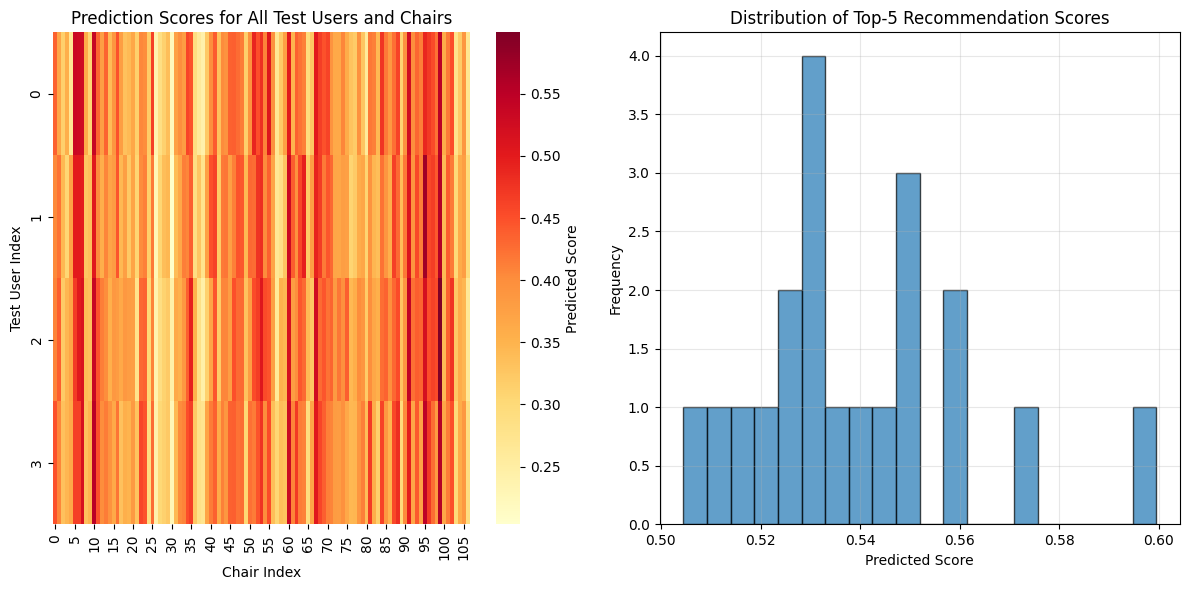

In [58]:
# 테스트 데이터의 추천 점수 분포 시각화
plt.figure(figsize=(12, 6))

# 각 테스트 사용자별 모든 의자에 대한 점수 히트맵
plt.subplot(1, 2, 1)
sns.heatmap(test_all_scores, cmap='YlOrRd', cbar_kws={'label': 'Predicted Score'})
plt.xlabel('Chair Index')
plt.ylabel('Test User Index')
plt.title('Prediction Scores for All Test Users and Chairs')

# Top-5 추천 점수 분포
plt.subplot(1, 2, 2)
all_top_scores = []
for person_idx in range(len(test_recommendations)):
    all_top_scores.extend(test_recommendations[person_idx]['scores'])

plt.hist(all_top_scores, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Score')
plt.ylabel('Frequency')
plt.title('Distribution of Top-5 Recommendation Scores')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [59]:
# 테스트 사용자들의 신체 특성과 추천 의자 특성 비교 분석
def analyze_test_recommendations(person_test_processed, test_recommendations, chair_processed):
    """
    테스트 사용자의 신체 특성과 추천된 의자 특성을 비교 분석
    """
    analysis_results = []
    
    for person_idx in range(len(person_test_processed)):
        person = person_test_processed.iloc[person_idx]
        rec = test_recommendations[person_idx]
        
        # Top-1 추천 의자 분석
        top_chair_idx = rec['chair_indices'][0]
        chair = chair_processed.iloc[top_chair_idx]
        
        analysis = {
            'person': person['image-name'],
            'buttock_popliteal_diff': chair['t4'] - person['A_Buttock-popliteal length'] if 't4' in chair else None,
            'seat_height_diff': chair['h8'] - person['B_Popliteal-height'] if 'h8' in chair else None,
            'hip_breadth_diff': chair['b3'] - person['C_Hip-breadth'] if 'b3' in chair else None,
            'backrest_height_diff': chair['h7'] - person['F_Sitting-height'] if 'h7' in chair else None,
            'shoulder_breadth_diff': chair['b4'] - person['G_Shoulder-breadth'] if 'b4' in chair else None,
            'prediction_score': rec['scores'][0]
        }
        
        analysis_results.append(analysis)
    
    return pd.DataFrame(analysis_results)

# 분석 실행
analysis_df = analyze_test_recommendations(person_test_processed, test_recommendations, chair_processed)

print("\n테스트 사용자와 Top-1 추천 의자 간 차이 분석:")
print(analysis_df.to_string())

# 분석 결과 저장
analysis_df.to_excel('test_recommendation_analysis.xlsx', index=False)
print("\n분석 결과가 'test_recommendation_analysis.xlsx'에 저장되었습니다.")

KeyError: 'F_Sitting-height'

In [60]:
# 먼저 실제 컬럼명을 확인해봅시다
print("Person processed columns:", person_processed.columns.tolist())
print("\nPerson test processed columns:", person_test_processed.columns.tolist())

Person processed columns: ['image-name', 'A_Buttock-popliteal length', 'B_Popliteal-height', 'C_Hip-breadth', 'G_Shoulder-breadth']

Person test processed columns: ['image-name', 'A_Buttock-popliteal length', 'B_Popliteal-height', 'C_Hip-breadth', 'G_Shoulder-breadth']


In [61]:
# 컬럼명 확인 후 분석 함수 수정
def analyze_test_recommendations(person_test_processed, test_recommendations, chair_processed):
    """
    테스트 사용자의 신체 특성과 추천된 의자 특성을 비교 분석
    """
    analysis_results = []
    
    # 실제 사용 가능한 컬럼명 확인
    person_columns = person_test_processed.columns.tolist()
    chair_columns = chair_processed.columns.tolist()
    
    for person_idx in range(len(person_test_processed)):
        person = person_test_processed.iloc[person_idx]
        rec = test_recommendations[person_idx]
        
        # Top-1 추천 의자 분석
        top_chair_idx = rec['chair_indices'][0]
        chair = chair_processed.iloc[top_chair_idx]
        
        analysis = {
            'person': person['image-name'],
            'prediction_score': rec['scores'][0]
        }
        
        # 조건별로 컬럼 존재 여부 확인 후 계산
        if 't4' in chair_columns and 'A_Buttock-popliteal length' in person_columns:
            analysis['buttock_popliteal_diff'] = chair['t4'] - person['A_Buttock-popliteal length']
        
        if 'h8' in chair_columns and 'B_Popliteal-height' in person_columns:
            analysis['seat_height_diff'] = chair['h8'] - person['B_Popliteal-height']
        
        if 'b3' in chair_columns and 'C_Hip-breadth' in person_columns:
            analysis['hip_breadth_diff'] = chair['b3'] - person['C_Hip-breadth']
        
        if 'h7' in chair_columns and 'F_Sitting-height' in person_columns:
            analysis['backrest_height_diff'] = chair['h7'] - person['F_Sitting-height']
        
        if 'b4' in chair_columns and 'G_Shoulder-breadth' in person_columns:
            analysis['shoulder_breadth_diff'] = chair['b4'] - person['G_Shoulder-breadth']
        
        analysis_results.append(analysis)
    
    return pd.DataFrame(analysis_results)

# 분석 실행
analysis_df = analyze_test_recommendations(person_test_processed, test_recommendations, chair_processed)

print("\n테스트 사용자와 Top-1 추천 의자 간 차이 분석:")
print(analysis_df.to_string())

# 분석 결과 저장
analysis_df.to_excel('test_recommendation_analysis.xlsx', index=False)
print("\n분석 결과가 'test_recommendation_analysis.xlsx'에 저장되었습니다.")


테스트 사용자와 Top-1 추천 의자 간 차이 분석:
  person  prediction_score  seat_height_diff  hip_breadth_diff  shoulder_breadth_diff
0    할머니          0.550907              15.0              37.0                   18.0
1     다온          0.571766              11.0              44.0                   -7.0
2     민아          0.599505              20.0              31.0                   16.0
3     재원          0.557591              13.0              29.5                   12.0

분석 결과가 'test_recommendation_analysis.xlsx'에 저장되었습니다.


In [62]:
# 매칭 조건 만족도 확인 함수도 수정
def check_matching_conditions_test(person_test_processed, test_recommendations, chair_processed):
    """
    테스트 데이터에 대한 추천 결과가 매칭 조건을 얼마나 만족하는지 확인
    """
    condition_satisfaction = []
    
    # 실제 사용 가능한 컬럼명 확인
    person_columns = person_test_processed.columns.tolist()
    chair_columns = chair_processed.columns.tolist()
    
    for person_idx in range(len(person_test_processed)):
        person = person_test_processed.iloc[person_idx]
        rec = test_recommendations[person_idx]
        
        for rank, chair_idx in enumerate(rec['chair_indices']):
            chair = chair_processed.iloc[chair_idx]
            
            conditions = {
                'person': person['image-name'],
                'rank': rank + 1,
                'chair_idx': chair_idx,
            }
            
            # 각 조건을 컬럼 존재 여부 확인 후 체크
            satisfied_count = 0
            total_conditions = 0
            
            # 조건 1: t4 < A
            if 't4' in chair_columns and 'A_Buttock-popliteal length' in person_columns:
                conditions['condition_1_t4<A'] = 1 if chair['t4'] < person['A_Buttock-popliteal length'] else 0
                satisfied_count += conditions['condition_1_t4<A']
                total_conditions += 1
            
            # 조건 2: h8 ≈ B
            if 'h8' in chair_columns and 'B_Popliteal-height' in person_columns:
                conditions['condition_2_h8≈B'] = 1 if abs(chair['h8'] - person['B_Popliteal-height']) <= 5 else 0
                satisfied_count += conditions['condition_2_h8≈B']
                total_conditions += 1
            
            # 조건 3: b3 > C
            if 'b3' in chair_columns and 'C_Hip-breadth' in person_columns:
                conditions['condition_3_b3>C'] = 1 if chair['b3'] > person['C_Hip-breadth'] else 0
                satisfied_count += conditions['condition_3_b3>C']
                total_conditions += 1
            
            # 조건 4: h9 ≈ E
            if 'h9' in chair_columns and 'E_Elbow-rest-height' in person_columns:
                conditions['condition_4_h9≈E'] = 1 if abs(chair['h9'] - person['E_Elbow-rest-height']) <= 3 else 0
                satisfied_count += conditions['condition_4_h9≈E']
                total_conditions += 1
            
            # 조건 5: h7 < F
            if 'h7' in chair_columns and 'F_Sitting-height' in person_columns:
                conditions['condition_5_h7<F'] = 1 if chair['h7'] < person['F_Sitting-height'] else 0
                satisfied_count += conditions['condition_5_h7<F']
                total_conditions += 1
            
            # 조건 6: b4 ≥ G
            if 'b4' in chair_columns and 'G_Shoulder-breadth' in person_columns:
                conditions['condition_6_b4≥G'] = 1 if chair['b4'] >= person['G_Shoulder-breadth'] else 0
                satisfied_count += conditions['condition_6_b4≥G']
                total_conditions += 1
            
            # 전체 조건 만족도
            conditions['total_satisfied'] = satisfied_count
            conditions['total_conditions'] = total_conditions
            conditions['satisfaction_rate'] = satisfied_count / total_conditions if total_conditions > 0 else 0
            
            condition_satisfaction.append(conditions)
    
    return pd.DataFrame(condition_satisfaction)

# 조건 만족도 확인
condition_df = check_matching_conditions_test(person_test_processed, test_recommendations, chair_processed)

# Top-1 추천의 평균 만족도
top1_satisfaction = condition_df[condition_df['rank'] == 1]['satisfaction_rate'].mean()
print(f"\n테스트 데이터 Top-1 추천의 평균 조건 만족도: {top1_satisfaction:.2%}")

# 전체 Top-5 추천의 평균 만족도
overall_satisfaction = condition_df['satisfaction_rate'].mean()
print(f"테스트 데이터 Top-5 추천의 전체 평균 조건 만족도: {overall_satisfaction:.2%}")

# 조건별 만족도
print("\n조건별 만족도:")
for col in condition_df.columns:
    if col.startswith('condition_'):
        satisfaction = condition_df[col].mean()
        total_count = condition_df[col].count()
        print(f"  {col}: {satisfaction:.2%} (평가된 케이스: {total_count}개)")

# 결과 저장
condition_df.to_excel('test_condition_satisfaction.xlsx', index=False)
print("\n조건 만족도 분석이 'test_condition_satisfaction.xlsx'에 저장되었습니다.")


테스트 데이터 Top-1 추천의 평균 조건 만족도: 58.33%
테스트 데이터 Top-5 추천의 전체 평균 조건 만족도: 61.67%

조건별 만족도:
  condition_2_h8≈B: 0.00% (평가된 케이스: 20개)
  condition_3_b3>C: 100.00% (평가된 케이스: 20개)
  condition_6_b4≥G: 85.00% (평가된 케이스: 20개)

조건 만족도 분석이 'test_condition_satisfaction.xlsx'에 저장되었습니다.


In [63]:
# 디버깅을 위해 데이터 구조 확인
print("\n=== 데이터 구조 확인 ===")
print("\n1. Person test 데이터 컬럼:")
for col in person_test_processed.columns:
    print(f"  - {col}")

print("\n2. Chair 데이터 컬럼:")
for col in chair_processed.columns:
    print(f"  - {col}")

print("\n3. 첫 번째 테스트 사용자 데이터:")
if len(person_test_processed) > 0:
    first_person = person_test_processed.iloc[0]
    for col in person_test_processed.columns:
        print(f"  - {col}: {first_person[col]}")

print("\n4. 첫 번째 의자 데이터:")
if len(chair_processed) > 0:
    first_chair = chair_processed.iloc[0]
    for col in chair_processed.columns:
        print(f"  - {col}: {first_chair[col]}")


=== 데이터 구조 확인 ===

1. Person test 데이터 컬럼:
  - image-name
  - A_Buttock-popliteal length
  - B_Popliteal-height
  - C_Hip-breadth
  - G_Shoulder-breadth

2. Chair 데이터 컬럼:
  - chair_id
  - h8
  - h8_range
  - b3
  - h7
  - b4

3. 첫 번째 테스트 사용자 데이터:
  - image-name: 할머니
  - A_Buttock-popliteal length: 52
  - B_Popliteal-height: 35
  - C_Hip-breadth: 32.0
  - G_Shoulder-breadth: 33

4. 첫 번째 의자 데이터:
  - chair_id: 0.0
  - h8: 46.83697916666667
  - h8_range: 6.088541666666667
  - b3: 49.48421052631579
  - h7: 50.0
  - b4: 48.451219512195124
